# Build your own SRP corpus

This notebook demonstrates how to hash a *new* corpus of files into the single SRP space. This lets you do the same sort of analysis that you might using PCA or LSA or some other technique; it *also* lets you make the features play nicely with the released Hathi Features. (See the other notebook for a demonstration).

As an example, it uses the 450 novels from McGill's Text Lab. These are in three different languages (German, English, and French), so it's a good example of why you should use SRP features rather than something English specific.

Another notebook in this collection demonstrates using this vectorized corpus to identify the Hathi Trust scans that are closest to the books described here.

In [1]:
import SRP
import os

This describes where the files are. Although it makes the code harder to run, I don't want to directly script downloading 100MB of text from figshare. You can get the files from here: https://figshare.com/articles/txtlab_Novel450/2062002/3.


In [2]:
filenames = os.listdir("/home/bschmidt/bookworms/txtlab/")
filenames = [f for f in filenames if f.endswith(".txt")]
filenames[:10]

['EN_1805_Lewis,Matthew_TheBravoofVenice_Novel.txt',
 'DE_1905_Meysenbug,Malwida_HimmlischeundirdischeLiebe_Novel.txt',
 'EN_1888_Ward,Mrs.Humphry_RobertElsmere_Novel.txt',
 'EN_1843_Borrow,George_TheBibleinSpain_Novel.txt',
 "FR_1853_DuCamp,Maxime_Memoiresd'uneSuicide_Novel.txt",
 'DE_1791_Klinger,Friedrich_FaustsLeben_Novel.txt',
 'DE_1787_Heinse,Johann_Ardinghello_Novel.txt',
 'DE_1843_Lewald,Fanny_Jenny_Novel.txt',
 'DE_1914_Kafka,Franz_Amerika_Novel.txt',
 'EN_1844_Yonge,Charlotte_Abbeychurch_Novel.txt']

First we create an SRP hasher object the same size as Hathi.

In [3]:
hasher = SRP.SRP(dim = 1280)

Next, we create a vector file to write the hashed objects to.


In [4]:
output = SRP.Vector_file(filename="txtlab.bin", dims=1280, mode="w")

Finally, we hash each document into the space and write this to the new file. This will take a fair amount of time; I often figure that a single book about over a second to tokenize and hash, so 450 books should take on order of five minutes.

In [5]:
for fname in filenames:
    with open("/home/bschmidt/bookworms/txtlab/" + fname) as fin:
        # Load the text.
        input = fin.read()
        # Spaces are not currently allowed in ids.
        id = fname.replace(" ","_").replace(".txt","")
        # Do the transformation according to the default rules. Stable_transform takes
        # a string of any length as input, and returns a numpy array suitable
        # for writing to disk.
        hash = hasher.stable_transform(input)
        # Add the newly hashed row to the output writer.
        output.add_row(id,hash)

# It's important to close the writer object; important information is only added at the end.
output.close()

In [6]:
id

'FR_1795_Genlis,StephanieFelicite,ComtesseDe_LesChevaliersDuCygneOuLaCourDeCharlemagne_Novel'

# Reading in an an existing file for exploration

Now that we've written out the file, we can read it in. (We could have just stored the ids and projections as we read it, as well, but I'm separating for clarity.)

Working with this kind of data is easier with a few additional imports.

In [7]:
import numpy as np
import sklearn.decomposition
import ggplot
import pandas as pd
import re

Now we read the rows and labels in. There's a convenience method, `to_matrix()`, to do this.

In [8]:
txtlab = SRP.Vector_file("txtlab.bin").to_matrix()
labels = txtlab["names"]

txtlab_matrix = txtlab["matrix"]

We'll  do something very simple: Use principle components analysis to see the major clusters within the corpus. Naturally, the primary separation will happen by language. Plotting shows that the dimensions here complete separate the three languages.

The first principal component runs from left to right. It places German to one side and French to the other, with English in between but closer to German. That's a nice result in itself, possibly reflecting the balance of similarly-spelled cognates among the three languages. The second dimension then elevates English away from the other two languages.

In [9]:
pca = sklearn.decomposition.pca.PCA(n_components=2)
pca.fit(txtlab_matrix)
t = pca.transform(txtlab_matrix)
pcs = pd.DataFrame(t,columns=["pc1","pc2"])

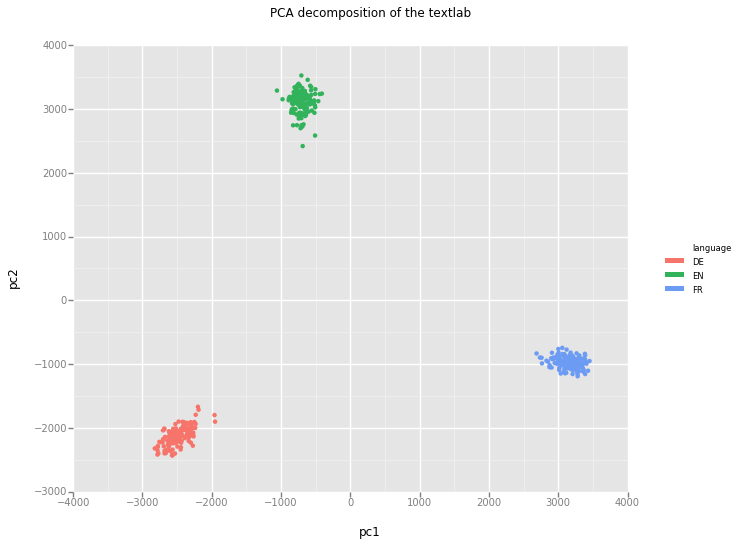

<ggplot: (8794097338149)>

In [10]:
pcs["language"] = [label[:2] for label in labels]
pcs.columns = ["pc1","pc2","language"]
ggplot.ggplot(pcs,ggplot.aes(x="pc1",y="pc2",color="language")) + ggplot.geom_point() + ggplot.labs(title="PCA decomposition of the textlab")

PCA is also reasonably effective inside this space with an individual language. In English, the score on the first principal component has a strong linear correlation with year of publication: this line slopes up and to the right because the old novels have the lowest score.

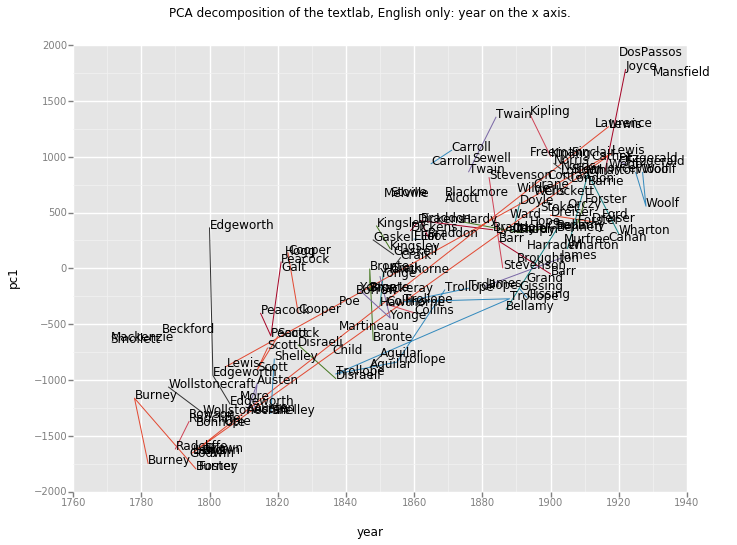

<ggplot: (8794095198049)>

In [11]:
pca = sklearn.decomposition.pca.PCA(n_components=2)
pca.fit(txtlab_matrix[pcs["language"]=="EN"])
t = pca.transform(txtlab_matrix)
just_english = pd.DataFrame(t,columns=["pc1","pc2"])
just_english["language"] = [label[:2] for label in labels]
just_english["author"] = [re.sub(r".*\d{4}_([^_]+)_.*","\\1",l.replace("_Novel","")).split(",")[0] for l in labels]
just_english["year"] = [int(re.sub(r".*(\d{4})_[^_]+_.*","\\1",l)) for l in labels]

just_english = just_english[just_english["language"]=="EN"]
ggplot.ggplot(just_english,ggplot.aes(x="year",y="pc1",label="author")) + \
ggplot.geom_text() + ggplot.labs(title="PCA decomposition of the textlab, English only: year on the x axis.")
